# test_model_bioinfo

In [1]:
# torch utils
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import math
import copy
# from MITNet.MITNet import MITNet

# prot-bert tokenizer
from transformers import BertForMaskedLM, BertTokenizerFast, pipeline, BertTokenizer
from torch.nn.utils.rnn import pad_sequence

# data analysis
import pandas as pd
import matplotlib.pyplot as plt

# training
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import tqdm

/home/cpsc452_xc392/.conda/envs/cpsc552/lib/python3.12/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/home/cpsc452_xc392/.conda/envs/cpsc552/lib/python3.12/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/home/cpsc452_xc392/.conda/envs/cpsc552/lib/python3.12/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [2]:
# run on gpu
if torch.cuda.is_available():
    device = torch.device("cuda")
    DEVICE_NAME = 'cuda'
    print("CUDA is available! Running on GPU.")
else:
    device = torch.device("cpu")
    DEVICE_NAME = 'cpu'
    print("CUDA is not available. Running on CPU.")

CUDA is available! Running on GPU.


## Encode bio info description

In [3]:
# Load the CSV file
file_path = "clean_data.csv"
df = pd.read_csv(file_path)

# Display the first few rows of the loaded data
print(df.shape)

(5503, 24)


In [4]:
df.columns

Index(['Epitope - Name', 'Assay - Qualitative Measure',
       'Epitope - Object Type', 'Epitope - Starting Position',
       'Epitope - Ending Position', 'Epitope - Source Molecule',
       'Epitope - Source Organism', 'Host - Name', 'Host - Age',
       '1st in vivo Process - Process Type', '1st in vivo Process - Disease',
       '1st in vivo Process - Disease Stage', 'Adoptive Transfer - Flag',
       'Assay - Method', 'Assay - Response measured',
       'Assay - Response Frequency (%)',
       'Assay Antibody - Antibody Source Material',
       'Assay Antibody - Immunoglobulin Domain',
       'Assay Antibody - Purification Status',
       'Assay Antibody - Heavy chain isotype',
       'Assay Antigen - Epitope Relation', 'Assay Antigen - Object Type',
       'Assay Antigen - Source Organism', 'Assay Antigen - Species'],
      dtype='object')

In [5]:
description = []

for index, row in df.iterrows():
    desc = ""
    for col in df.columns:
        if col not in set(['Epitope - Name', 'Assay - Qualitative Measure']):
            col_name = col.replace("- ", "")
            desc += f"{col_name} {row[col]} . "
    description.append(desc)

df['description'] = description

In [6]:
df['description']

0       Epitope Object Type Linear peptide . Epitope S...
1       Epitope Object Type Linear peptide . Epitope S...
2       Epitope Object Type Linear peptide . Epitope S...
3       Epitope Object Type Linear peptide . Epitope S...
4       Epitope Object Type Linear peptide . Epitope S...
                              ...                        
5498    Epitope Object Type Linear peptide . Epitope S...
5499    Epitope Object Type Linear peptide . Epitope S...
5500    Epitope Object Type Linear peptide . Epitope S...
5501    Epitope Object Type Linear peptide . Epitope S...
5502    Epitope Object Type Linear peptide . Epitope S...
Name: description, Length: 5503, dtype: object

In [7]:
# use bert tokenizer
tokenizer = BertTokenizerFast.from_pretrained("google-bert/bert-base-uncased")
BERT_VOCAB = len(tokenizer.vocab)

In [8]:
# pro_bert tokenizer
df['Tokenized_description'] = df['description'].apply(lambda x: tokenizer(x)['input_ids'])
pad_descriptions = pad_sequence([torch.tensor(seq) for seq in df['Tokenized_description']], padding_value=tokenizer.vocab["[PAD]"], batch_first=True)

In [9]:
pad_descriptions.shape

torch.Size([5503, 251])

## Epitope sequences

In [10]:
target_col = "Assay - Qualitative Measure"
feature_col = "Epitope - Name"
filtered_df = df[[feature_col, target_col]]

# pro_bert tokenizer
tokenizer = BertTokenizer.from_pretrained("Rostlab/prot_bert", do_lower_case=False )
PROBERT_VOCAB = len(tokenizer.vocab)
filtered_df['Tokenized_Epitope'] = filtered_df['Epitope - Name'].apply(lambda x: tokenizer(" ".join(x))['input_ids'])
pad_sequences = pad_sequence([torch.tensor(seq) for seq in filtered_df['Tokenized_Epitope']], padding_value=tokenizer.vocab["[PAD]"], batch_first=True)

/tmp/ipykernel_3347732/1875776390.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Tokenized_Epitope'] = filtered_df['Epitope - Name'].apply(lambda x: tokenizer(" ".join(x))['input_ids'])


## BioFusion-MITNet

In [11]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        # Ensure that the model dimension (d_model) is divisible by the number of heads
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"
        
        # Initialize dimensions
        self.d_model = d_model # Model's dimension
        self.num_heads = num_heads # Number of attention heads
        self.d_k = d_model // num_heads # Dimension of each head's key, query, and value
        
        # Linear layers for transforming inputs
        self.W_q = nn.Linear(d_model, d_model) # Query transformation
        self.W_k = nn.Linear(d_model, d_model) # Key transformation
        self.W_v = nn.Linear(d_model, d_model) # Value transformation
        self.W_o = nn.Linear(d_model, d_model) # Output transformation
        
    def scaled_dot_product_attention(self, Q, K, V, mask=None):
        # Calculate attention scores
        attn_scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)
        
        # Apply mask if provided (useful for preventing attention to certain parts like padding)
        if mask is not None:
            attn_scores = attn_scores.masked_fill(mask == 0, -1e9)
        
        # Softmax is applied to obtain attention probabilities
        attn_probs = torch.softmax(attn_scores, dim=-1)
        
        # Multiply by values to obtain the final output
        output = torch.matmul(attn_probs, V)
        return output
        
    def split_heads(self, x):
        # Reshape the input to have num_heads for multi-head attention
        batch_size, seq_length, d_model = x.size()
        return x.view(batch_size, seq_length, self.num_heads, self.d_k).transpose(1, 2)
        
    def combine_heads(self, x):
        # Combine the multiple heads back to original shape
        batch_size, _, seq_length, d_k = x.size()
        return x.transpose(1, 2).contiguous().view(batch_size, seq_length, self.d_model)
        
    def forward(self, Q, K, V, mask=None):
        # Apply linear transformations and split heads
        Q = self.split_heads(self.W_q(Q))
        K = self.split_heads(self.W_k(K))
        V = self.split_heads(self.W_v(V))
        
        # Perform scaled dot-product attention
        attn_output = self.scaled_dot_product_attention(Q, K, V, mask)
        
        # Combine heads and apply output transformation
        output = self.W_o(self.combine_heads(attn_output))
        return output
    
# NOTE: Redefine FF for MITNet
class CovFeedForward(nn.Module):
    def __init__(self, d_model, d_ff, in_channel, eps = 1e-6, dropout=0.2, ):
        super(CovFeedForward, self).__init__()
        self.norm1 = nn.LayerNorm(d_model, eps=eps)
        # First convolutional filters, kernel size and activation: 4, 1, 'relu'
        self.cov1 = nn.Conv1d(in_channel, d_ff, kernel_size=1)
        # Second convolutional filters and kernel size: number of channel inputs, 1
        self.cov2 = nn.Conv1d(d_ff, in_channel, kernel_size=1)
        self.channel_input = d_ff
        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        # Layer normalization
        x = self.norm1(x)
        # First convolutional layer
        x = self.cov1(x)
        # ReLU activation
        x = self.relu(x)
        # Dropout
        x = self.dropout(x)
        # Second convolutional layer
        x = self.cov2(x)
        return x

In [12]:
# NOTE: transformer block in figure 4
class TransformerBlock(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, in_channel, dropout=0.25, eps=1e-6):
        super(TransformerBlock, self).__init__()
        self.norm1 = nn.LayerNorm(d_model, eps=eps)
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.dropout = nn.Dropout(dropout)
        self.cov_ff = CovFeedForward(d_model, d_ff, in_channel, eps=1e-6, dropout=0.2)
    
    def forward(self, x, mask):
        res = x
        # Layer normalization
        x = self.norm1(x)
        # Multihead Attention
        x = self.self_attn(x, x, x, mask)
        # Dropout
        x = self.dropout(x)
        x += res

        # FeedFoward
        res = x
        x = self.cov_ff(x)
        return x + res
    
class ClassificationBlock(nn.Module):
    def __init__(self, input_dim, dropout, output_class=2, hidden_dim=128):
        super(ClassificationBlock, self).__init__()
        # TODO: 
        self.global_avg_pooling = nn.AdaptiveAvgPool1d(1)  # Global Average Pooling
        self.mlp1 = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),  # MLP Layer 1
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        self.mlp2 = nn.Linear(hidden_dim, output_class)  # Output MLP
        
    def forward(self, x):
        # Global Average Pooling
        out = self.global_avg_pooling(x.permute(0, 2, 1)).squeeze(2) 
        # MLP
        out = self.mlp1(out)
        # Output MLP
        out = self.mlp2(out)
        return F.softmax(out, dim=1)  # Softmax activation for classification
    
class TransformerMITNet(nn.Module):
    def __init__(self, src_vocab_size, d_model, num_heads, num_layers, d_ff, in_channel, trans_dropout, class_dropout, max_seq_length=64):
        super(TransformerMITNet, self).__init__()
        '''
        Transformer head MITNet:
        (1) Embedding (one-hot/our choice)
        (2) Transformer blocks * 4
        (3) Classification block
        '''
        # TODO: replace this with our own encoding method
        self.embedding = nn.Embedding(src_vocab_size, d_model)
        # NOTE: may not need positional encoding for our project
        # self.positional_encoding = PositionalEncoding(d_model, max_seq_length)

        # Transformer blocks
        self.transformer_blocks = nn.ModuleList([TransformerBlock(d_model, num_heads, d_ff, in_channel, dropout=trans_dropout) for _ in range(num_layers)])
        # Classification
        self.classification_block = ClassificationBlock(d_model, dropout=class_dropout, output_class=2, hidden_dim=128)

    def generate_mask(self, src):
        src_mask = (src != torch.tensor(0, dtype=src.dtype)).unsqueeze(1).unsqueeze(2)
        return src_mask
    
    def forward(self, src):
        # src_embedded = self.positional_encoding(self.encoder_embedding(src))
        src_embedded = self.embedding(src)
        src_mask = self.generate_mask(src)
        tran_output = src_embedded
        for tran_layer in self.transformer_blocks:
            tran_output = tran_layer(tran_output, src_mask)
        return self.classification_block(tran_output)

In [13]:
class DenseLayer(nn.Module):
    def __init__(self, input_dim, hidden_dims=[16, 64, 16]):
        super(DenseLayer, self).__init__()
        self.dense_1 = nn.Linear(input_dim, hidden_dims[0])
        self.dense_2 = nn.Linear(hidden_dims[0],  hidden_dims[1])
        self.dense_3 = nn.Linear(hidden_dims[1],  hidden_dims[2])
        self.activation = nn.LeakyReLU()
    
    def forward(self, x):
        x = self.activation(self.dense_1(x))
        x = self.activation(self.dense_2(x))
        x = self.activation(self.dense_3(x))
        return x

class DenseNetwork(nn.Module):
    def __init__(self, input_dim, n_stack=1, hidden_dims=[16, 64, 16]):
        super(DenseNetwork, self).__init__()
        self.DenseNet = nn.ModuleList([DenseLayer(input_dim, hidden_dims) for _ in range(n_stack)])
        self.BatchNorm = nn.BatchNorm1d(hidden_dims[-1])

    def forward(self, x):
        for module in self.DenseNet:
            x = module(x)
        x = self.BatchNorm(x)
        return x

In [14]:
class ClassificationNet(nn.Module):
    def __init__(self, input_dim, hidden_dim=2):
        super(ClassificationNet, self).__init__()
        self.dense = nn.Linear(input_dim, hidden_dim)
        self.output = nn.Softmax(dim=1)
    
    def forward(self, x):
        return self.output(self.dense(x))

In [37]:
class MITNet_bio(nn.Module):
    def __init__(self, src_vocab_sizes, in_channel, d_model=[32, 128], num_heads=4, num_layers=4, d_ff=4, trans_dropout=0.25, class_dropout=0.1):
        super(MITNet_bio, self).__init__()
        # transformer: output class 0 or 1
        self.transformer = TransformerMITNet(src_vocab_sizes[0], d_model[0], num_heads, num_layers, d_ff, in_channel[0], trans_dropout, class_dropout)
        self.transformer_2 = TransformerMITNet(src_vocab_sizes[1], d_model[1], 16, 1, d_ff, in_channel[1], trans_dropout, class_dropout)
        # dense network
        self.dense = DenseNetwork(input_dim=4, n_stack=1, hidden_dims=[16, 64, 16])
        # classification network: input 16, output 2
        self.classification = ClassificationNet(input_dim=16, hidden_dim=2)

    def forward(self, input, sequence_len):
        input_1 = input[:, :sequence_len]
        input_2 = input[:, sequence_len:]
        x = self.transformer(input_1)
        y = self.transformer_2(input_2)
        out = torch.cat((x, y), dim=1) # concatenate two outputs
        out = self.dense(out)
        return self.classification(out)

In [16]:
# # test forward
# target_tensor = torch.tensor(filtered_df["Assay - Qualitative Measure"].values, dtype=torch.long)

# src_vocab_size = [PROBERT_VOCAB, BERT_VOCAB]
# in_channel = [pad_sequences.shape[1], pad_descriptions.shape[1]]
# model = MITNet_bio(src_vocab_size, in_channel).to(device)
# pred = model(pad_sequences.to(device), pad_descriptions.to(device))

## Training Experiment I

Training details:
* Model: BioMITNet
* Optimizer Adam: lr = 1e-4
* Training Epochs: 30
* Loss Function: Cross Entropy Loss
* Traing validation split: 8:2
* Batch Size: 16

In [69]:
# change to cuda
src_vocab_size = [PROBERT_VOCAB, BERT_VOCAB]
SEQ_LEN = pad_sequences.shape[1]
in_channel = [pad_sequences.shape[1], pad_descriptions.shape[1]]
target_tensor = torch.tensor(filtered_df["Assay - Qualitative Measure"].values, dtype=torch.long)
input_ids = torch.cat((pad_sequences, pad_descriptions), dim=1).to(device)
target_tensor = target_tensor.to(device)

# Create a TensorDataset
dataset = TensorDataset(input_ids, target_tensor)

# Split dataset into training and validation sets
train_indices, val_indices = train_test_split(range(len(dataset)), test_size=0.2, random_state=42)

batch_size = 16
# Create DataLoader for training set
train_sampler = torch.utils.data.SubsetRandomSampler(train_indices)
train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
# Create DataLoader for validation set
val_sampler = torch.utils.data.SubsetRandomSampler(val_indices)
val_loader = DataLoader(dataset, batch_size=batch_size, sampler=val_sampler)

In [70]:
# Define your loss function and optimizer
model = MITNet_bio(src_vocab_size, in_channel).to(device)
criterion = nn.CrossEntropyLoss()
learning_rate = 1e-4
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [71]:
# Training loop
num_epochs = 30
training_loss_list = []
training_acc_list = []
for epoch in range(num_epochs):
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    
    for inputs, labels in train_loader:
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs, SEQ_LEN)

        # Compute the loss
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Update running loss
        running_loss += loss.item()

        # Calculate training accuracy
        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_samples += labels.size(0)
    
    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = correct_predictions / total_samples
    training_loss_list.append(epoch_loss)
    training_acc_list.append(epoch_accuracy)
    if epoch%5==0:
        print(f'Epoch {epoch+1}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}')

print('Training finished')

Epoch 1, Loss: 0.5971, Accuracy: 0.7099
Epoch 6, Loss: 0.3777, Accuracy: 0.9425
Epoch 11, Loss: 0.3678, Accuracy: 0.9480
Epoch 16, Loss: 0.3733, Accuracy: 0.9418
Epoch 21, Loss: 0.3699, Accuracy: 0.9439
Epoch 26, Loss: 0.3669, Accuracy: 0.9478
Training finished


Text(0.5, 0, 'Epochs')

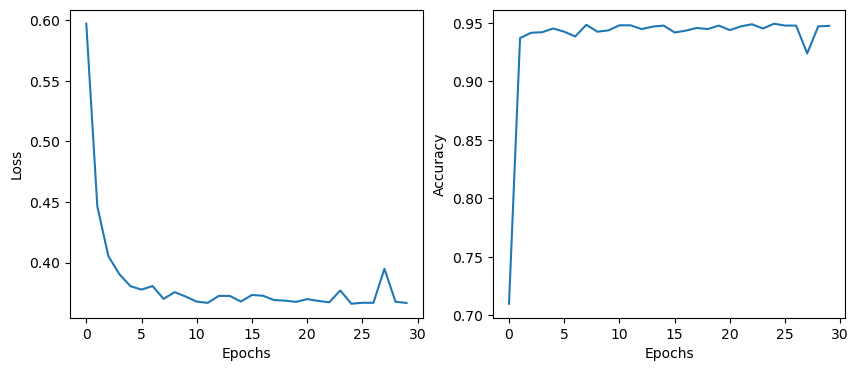

In [72]:
# plot loss vs epochs
fig = plt.figure(figsize = (10, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(range(num_epochs), training_loss_list)
ax.set_ylabel('Loss')
ax.set_xlabel('Epochs')

ax = fig.add_subplot(1, 2, 2)
ax.plot(range(num_epochs), training_acc_list)
ax.set_ylabel('Accuracy')
ax.set_xlabel('Epochs')

In [73]:
from sklearn.metrics import roc_auc_score, f1_score

# Evaluation function
def evaluate(model, dataloader):
    model.eval()
    correct_predictions = 0
    total_samples = 0
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            outputs = model(inputs, SEQ_LEN)
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()
            total_samples += labels.size(0)

            all_labels.extend(labels.tolist())
            all_preds.extend(predicted.tolist())

    accuracy = correct_predictions / total_samples
    roc_auc = roc_auc_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)

    return accuracy, roc_auc, f1

# Perform validation
val_accuracy, val_roc_auc, val_f1 = evaluate(model, val_loader)

print(f'Validation Accuracy: {val_accuracy:.4f}')
print(f'ROC AUC Score: {val_roc_auc:.4f}')
print(f'F1 Score: {val_f1:.4f}')

Validation Accuracy: 0.9500
ROC AUC Score: 0.9655
F1 Score: 0.9170


In [74]:
# save model
torch.save(model.state_dict(), 'biomitnet_adam_model.pth')

In [75]:
# load model
src_vocab_size = [PROBERT_VOCAB, BERT_VOCAB]
SEQ_LEN = pad_sequences.shape[1]
in_channel = [pad_sequences.shape[1], pad_descriptions.shape[1]]
model = MITNet_bio(src_vocab_size, in_channel).to(device)

# Load the model's state dict from the saved file
model.load_state_dict(torch.load('biomitnet_adam_model.pth'))

# Put the model in evaluation mode
val_accuracy, val_roc_auc, val_f1 = evaluate(model, val_loader)

print(f'Validation Accuracy: {val_accuracy:.4f}')
print(f'ROC AUC Score: {val_roc_auc:.4f}')
print(f'F1 Score: {val_f1:.4f}')

Validation Accuracy: 0.9500
ROC AUC Score: 0.9655
F1 Score: 0.9170


In [76]:
performance = {}
performance["BioMITNet-Adam"]={
    "Accuracy": val_accuracy,
    "ROC-AUC Score":val_roc_auc,
    "F1 Score": val_f1
    }

## Training Experiment II

Training details:
* Model: BioMITNet
* Optimizer AdamW: lr = 1e-4, weight decay = 1e-5
* Training Epochs: 50
* Loss Function: Cross Entropy Loss
* Traing validation split: 8:2
* Batch Size: 16

In [77]:
# Define your loss function and optimizer
model = MITNet_bio(src_vocab_size, in_channel).to(device)
criterion = nn.CrossEntropyLoss()
learning_rate = 1e-4
optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-5)

In [78]:
# Training loop
num_epochs = 30
training_loss_list = []
training_acc_list = []
for epoch in range(num_epochs):
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    
    for inputs, labels in train_loader:
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs, SEQ_LEN)

        # Compute the loss
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Update running loss
        running_loss += loss.item()

        # Calculate training accuracy
        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_samples += labels.size(0)
    
    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = correct_predictions / total_samples
    training_loss_list.append(epoch_loss)
    training_acc_list.append(epoch_accuracy)
    if epoch%5==0:
        print(f'Epoch {epoch+1}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}')

print('Training finished')

Epoch 1, Loss: 0.5986, Accuracy: 0.8137
Epoch 6, Loss: 0.3745, Accuracy: 0.9478
Epoch 11, Loss: 0.3684, Accuracy: 0.9475
Epoch 16, Loss: 0.3492, Accuracy: 0.9650
Epoch 21, Loss: 0.3499, Accuracy: 0.9648
Epoch 26, Loss: 0.3483, Accuracy: 0.9652
Training finished


Text(0.5, 0, 'Epochs')

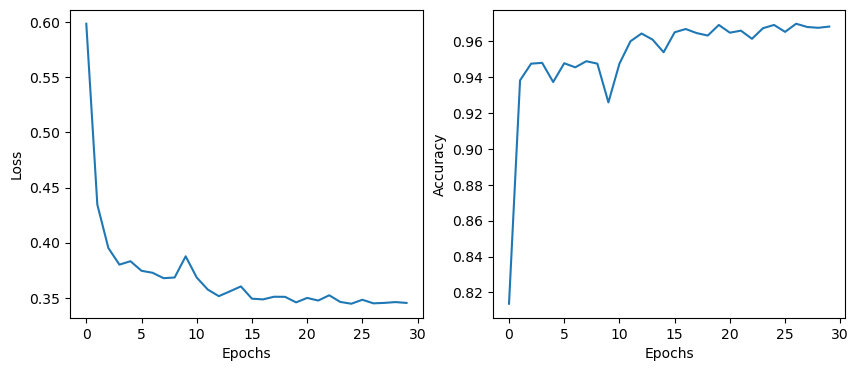

In [79]:
# plot loss vs epochs
fig = plt.figure(figsize = (10, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(range(num_epochs), training_loss_list)
ax.set_ylabel('Loss')
ax.set_xlabel('Epochs')

ax = fig.add_subplot(1, 2, 2)
ax.plot(range(num_epochs), training_acc_list)
ax.set_ylabel('Accuracy')
ax.set_xlabel('Epochs')

In [80]:
# Perform validation
val_accuracy, val_roc_auc, val_f1 = evaluate(model, val_loader)

print(f'Validation Accuracy: {val_accuracy:.4f}')
print(f'ROC AUC Score: {val_roc_auc:.4f}')
print(f'F1 Score: {val_f1:.4f}')

Validation Accuracy: 0.9637
ROC AUC Score: 0.9749
F1 Score: 0.9383


In [81]:
# save model
torch.save(model.state_dict(), 'biomitnet_adamW_model.pth')

In [82]:
# load model
src_vocab_size = [PROBERT_VOCAB, BERT_VOCAB]
SEQ_LEN = pad_sequences.shape[1]
in_channel = [pad_sequences.shape[1], pad_descriptions.shape[1]]
model = MITNet_bio(src_vocab_size, in_channel).to(device)

# Load the model's state dict from the saved file
model.load_state_dict(torch.load('biomitnet_adamW_model.pth'))

# Put the model in evaluation mode
val_accuracy, val_roc_auc, val_f1 = evaluate(model, val_loader)

print(f'Validation Accuracy: {val_accuracy:.4f}')
print(f'ROC AUC Score: {val_roc_auc:.4f}')
print(f'F1 Score: {val_f1:.4f}')

Validation Accuracy: 0.9637
ROC AUC Score: 0.9749
F1 Score: 0.9383


In [83]:
performance["BioMITNet-AdamW"]={
    "Accuracy": val_accuracy,
    "ROC-AUC Score":val_roc_auc,
    "F1 Score": val_f1
    }

In [84]:
performance_df = pd.read_csv("performance_ctc_base.csv", index_col = 0)
performance_df

,MITNet-Adam,MITNet-AdamW
Accuracy,0.856494,0.858311
ROC-AUC Score,0.784896,0.787169
F1 Score,0.706320,0.710037


In [85]:
performance_df_bio = pd.DataFrame(performance)
performance_df_bio

,BioMITNet-Adam,BioMITNet-AdamW
Accuracy,0.950045,0.963669
ROC-AUC Score,0.965496,0.974906
F1 Score,0.917044,0.938272


In [86]:
concatenated_df = pd.concat([performance_df, performance_df_bio], axis=1)
concatenated_df

,MITNet-Adam,MITNet-AdamW,BioMITNet-Adam,BioMITNet-AdamW
Accuracy,0.856494,0.858311,0.950045,0.963669
ROC-AUC Score,0.784896,0.787169,0.965496,0.974906
F1 Score,0.706320,0.710037,0.917044,0.938272


In [87]:
concatenated_df.to_csv("performance_mitnet_all.csv")